<a href="https://colab.research.google.com/github/CFVV/MSc-assignments/blob/main/2022-2_Computer_Audition/T4_Low-Level%20Frequency%20Descriptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 4: Descriptores Frecuenciales de bajo nivel

### Autora: Camila Vera V.

In [ ]:
%matplotlib inline
from pylab import *
from IPython.html.widgets import interact, fixed
from IPython.display import display
from IPython.display import Audio
from scipy.signal import square
import re
import soundfile as sf
from scipy.io import wavfile
from scipy.stats import skew, kurtosis
import pandas as pd
import seaborn as sn
plt.rcParams['figure.figsize'] = (20,7)

import scipy.fftpack as fourier
from scipy.fft import fft, fftfreq
import scipy.io.wavfile as waves
import wave

/home/ignacio/anaconda3/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


# Pregunta 1: Sinusoides

In [ ]:
sine = waves.read("p1.wav")[1]

In [ ]:
segmented_sine = [sine[i*1024:(i+1)*1024] for i in range(int(sine.shape[0]/1024))]

In [ ]:
print(f'N° Segmentos obtenidos: {len(segmented_sine)}')

N° Segmentos obtenidos: 645


Amplitud real de la onda

In [ ]:
n_samples = 1024
get_max_amplitude = lambda x: np.max(2 / n_samples * np.abs(np.fft.fft(x)))

In [ ]:
amplitudes = np.array([get_max_amplitude(segmento) for segmento in segmented_sine])

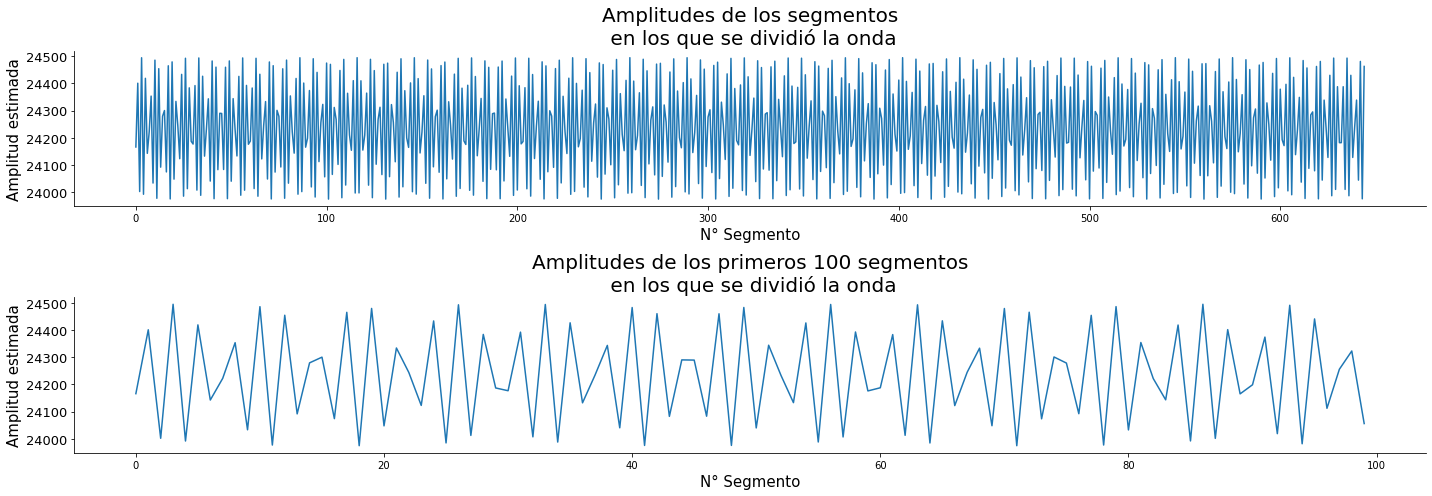

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(amplitudes.shape[0]), amplitudes, label = 'Secuencia de amplitudes estimadas para cada segmento')
plt.title('Amplitudes de los segmentos\n en los que se dividió la onda', fontsize = 20)
plt.xlabel('N° Segmento', fontsize = 15)
plt.ylabel('Amplitud estimada', fontsize = 15)
plt.yticks(fontsize = 13)
sn.despine()

plt.subplot(2,1,2)
plt.plot(range(amplitudes[:100].shape[0]), amplitudes[:100], label = 'Secuencia de amplitudes estimadas para cada segmento')
plt.title('Amplitudes de los primeros 100 segmentos\n en los que se dividió la onda', fontsize = 20)
plt.xlabel('N° Segmento', fontsize = 15)
plt.ylabel('Amplitud estimada', fontsize = 15)
plt.yticks(fontsize = 13)
sn.despine()

plt.tight_layout()

In [ ]:
np.max(amplitudes) - np.min(amplitudes)

520.0548145005996

Claramente hay diferencias entre las amplitudes estimadas para cada uno de los segmentos, esto se debe al fenómeno conocido como spectral leakage. El fenómeno de spectral leakage consiste en una discordancia en la frecuencia observada entre la onda original y una muestra de un segmento de esta onda, esto hace que la observada por la transformada de fourier sea distinta a la que debería, obteniendose distintos valores de amplitud. Se puede evitar usando ventanas no rectangulares para muestrear la señal.

# Pregunta 2: Sinusoides

In [ ]:
hamming_window = np.hamming(1024)

In [ ]:
hamming_sine = np.array([hamming_window*segmento for segmento in segmented_sine])

In [ ]:
hamming_amplitudes = np.array([get_max_amplitude(segmento) for segmento in hamming_sine])

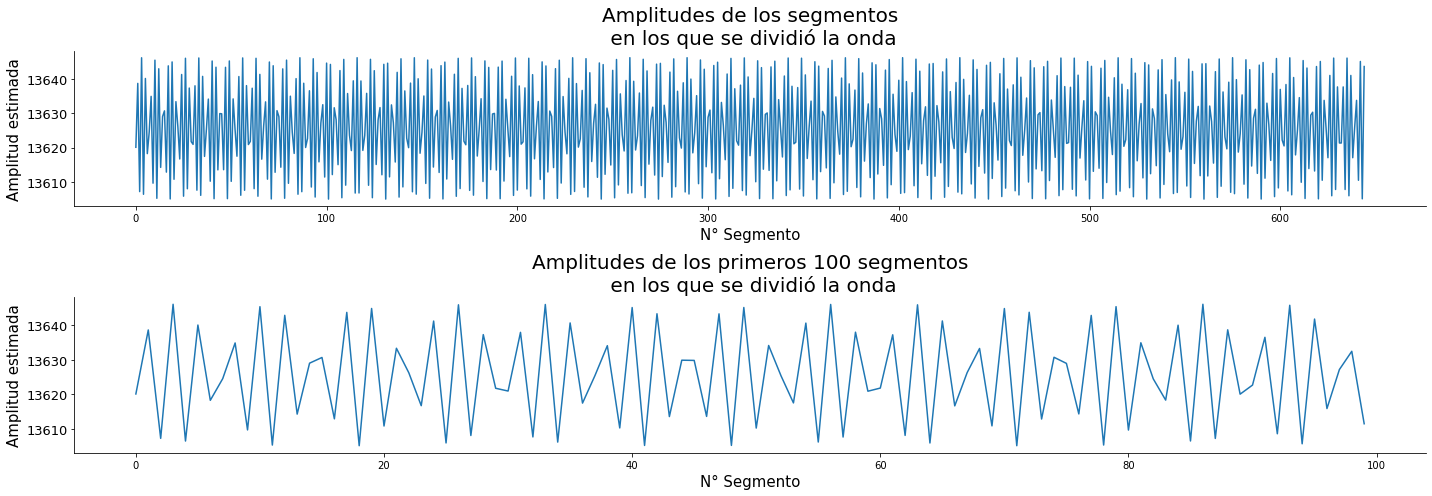

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(hamming_amplitudes.shape[0]), hamming_amplitudes, label = 'Secuencia de amplitudes estimadas para cada segmento')
plt.title('Amplitudes de los segmentos\n en los que se dividió la onda', fontsize = 20)
plt.xlabel('N° Segmento', fontsize = 15)
plt.ylabel('Amplitud estimada', fontsize = 15)
plt.yticks(fontsize = 13)
sn.despine()

plt.subplot(2,1,2)
plt.plot(range(hamming_amplitudes[:100].shape[0]), hamming_amplitudes[:100], label = 'Secuencia de amplitudes estimadas para cada segmento')
plt.title('Amplitudes de los primeros 100 segmentos\n en los que se dividió la onda', fontsize = 20)
plt.xlabel('N° Segmento', fontsize = 15)
plt.ylabel('Amplitud estimada', fontsize = 15)
plt.yticks(fontsize = 13)
sn.despine()

plt.tight_layout()

In [ ]:
np.max(hamming_amplitudes) - np.min(hamming_amplitudes)

41.06611067785161

El patrón de distorsión entre las amplitudes parece ser el mismo, sin embargo, el rango de estas distorsiones es considerablemente menor, sin la aplicación de la ventana se tenía un rango de $520$, mientras que al aplicar la ventana se tiene que la diferencia entre las amplitudes medidas es de $41$.

# Pregunta 3: Determinación de la frecuencia de amplitud máxima

Primero voy a probar para un solo segmento

In [ ]:
Fs=44100

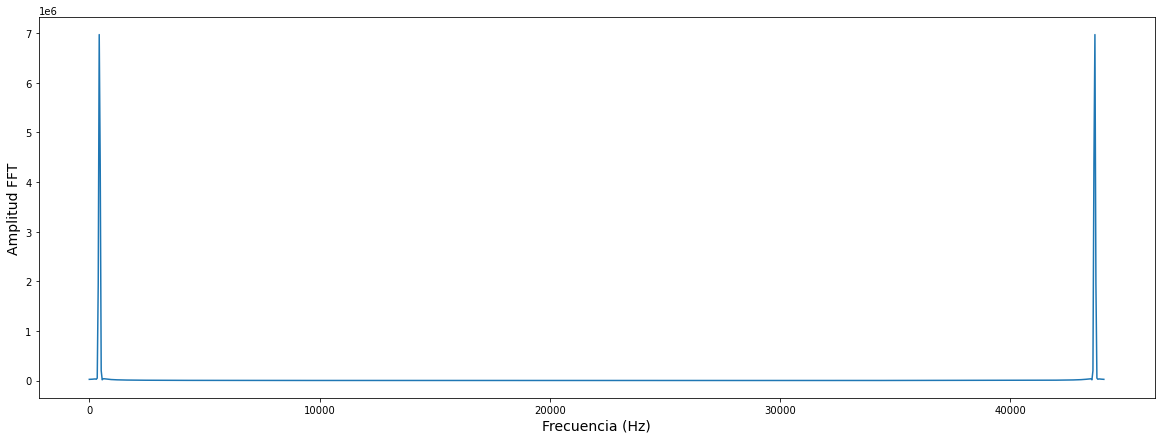

In [ ]:
gk = fourier.fft(hamming_sine[0])                             # Calculamos la FFT
M_gk = abs(gk)                                  # Calculamos la Magnitud de la FFT

F = Fs*np.arange(0, len(hamming_sine[0]))/len(hamming_sine[0])              # Definimos el Vector de Frecuencias

plt.plot(F, M_gk)
plt.xlabel('Frecuencia (Hz)', fontsize='14')
plt.ylabel('Amplitud FFT', fontsize='14')
plt.show()

In [ ]:
print(f'Frecuencia predominante: {F[np.argmax(M_gk[:len(M_gk)//2])]} [Hz]')

Frecuencia predominante: 430.6640625 [Hz]


Automatizandolo para cada segmento:

In [ ]:
def topFreq_from_amplitude(segment):
    Fs=44100 #Frecuencia de muestreo

    fft_segment = fourier.fft(segment) # Calculo de la transformada
    magnitud = abs(fft_segment)  # magnitudes
    F = Fs*np.arange(0, len(segment))/len(segment) # frecuencias
    return F[np.argmax(magnitud[:len(magnitud)//2])] # frecuencia con amplitud maxima



In [ ]:
top_freqs = [topFreq_from_amplitude(segmento) for segmento in hamming_sine]

Frecuencia de toda la onda

In [ ]:
topFreq_from_amplitude(sine)

440.0

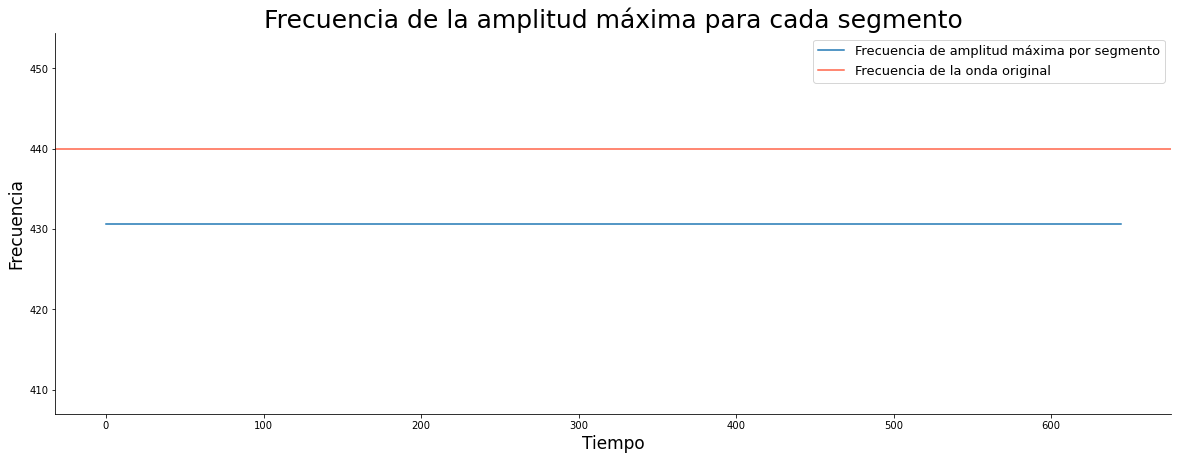

In [ ]:
plt.plot(range(len(top_freqs)),top_freqs, label = 'Frecuencia de amplitud máxima por segmento')
plt.title('Frecuencia de la amplitud máxima para cada segmento', fontsize = 25)
plt.axhline(topFreq_from_amplitude(sine), color = 'tomato', label = 'Frecuencia de la onda original')
plt.legend(fontsize = 13)
plt.xlabel('Tiempo', fontsize = 17)
plt.ylabel('Frecuencia', fontsize = 17)
sn.despine()

Todos los segmentos muestran la misma frecuencia de amplitud máxima, distinta a la real de la onda que es 440.

# pregunta 4: ¿Cómo se puede mejorar la resolución en frecuencia sin reducir la resolución temporal?

Para poder aumentar la resolución en frecuencia, sin reducir la resolución temporal se puede interpolar el espectro de frecuencias obtenido de la transformada discreta, de esta forma no se modifica la frecuencia de muestreo ni el tamaño de la ventana donde se aplica la transformación, manteniendo la resolución tempral intacta.

# Pregunta 5: Detección de notas

In [ ]:
rate, piano_wave = waves.read("piano.wav")

/tmp/ipykernel_12499/206167617.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, piano_wave = waves.read("piano.wav")


In [ ]:
piano

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [ 0.00092869,  0.00348169],
       [-0.00055463,  0.00493727],
       [-0.00062619,  0.00408097]], dtype=float32)

In [ ]:
downMixed_piano = np.array([np.mean([x[0], x[1]]) for x in piano])

In [ ]:
display(Audio(downMixed_piano, rate = rate))

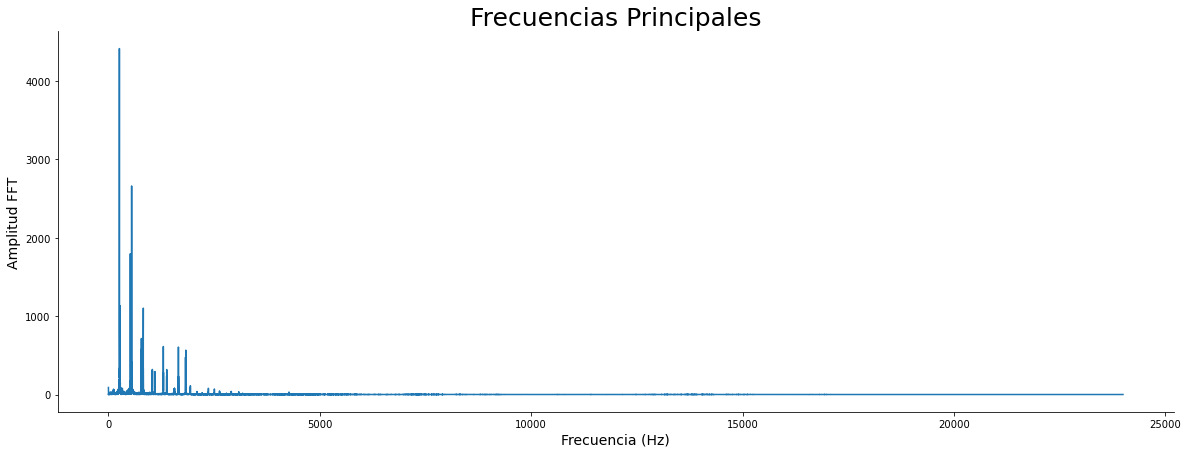

In [ ]:
Fs = rate
gk = fourier.fft(downMixed_piano)               # Calculamos la FFT
M_gk = abs(gk)                                  # Calculamos la Magnitud de la FFT

F = Fs*np.arange(0, len(downMixed_piano))/len(downMixed_piano)  # Definimos el Vector de Frecuencias

plt.plot(F[:len(F)//2], M_gk[:len(M_gk)//2])
plt.xlabel('Frecuencia (Hz)', fontsize=14)
plt.ylabel('Amplitud FFT', fontsize=14)
plt.title('Frecuencias Principales', fontsize = 25)

sn.despine()

Una parece tener valores cercanos a los $549 (Hz)$ mientras que la otra parece tener valores de frecuencia cercanos  alos $259 (Hz)$, revisando las frecuencias teóricas de las notas musicales, se puede ver que una frecuencia de $259 (Hz)$ es muy similar a la frecuencia teórica de una nota Do en la 4ta octava ($261.63 (Hz)$), mientras que la frecuencia de $549 (Hz)$ es similar a la frecuencia de un Do# en la 5ta octava ($554.37$). Si en efecto se tocó un $Do_{4}$ y un $Do\#_{5}$ entonces se podría afinar el piano de forma que estas frecuencias fuesen más similares a las teóricas.

In [ ]:
topFreq_from_amplitude(downMixed_piano)

238.40148532569793

In [ ]:
ind = np.argpartition(M_gk[:len(M_gk)//2], -10)[-10:]
top_freqs = F[ind[np.argsort(M_gk[:len(M_gk)//2][ind])]]

In [ ]:
top_freqs

array([259.30565497, 259.84251969, 548.67573372, 549.74946314,
       548.85468862, 258.41088046, 259.66356478, 258.76879026,
       259.12670007, 259.48460988])

# Pregunta 7: Cálculo de descriptores frecuenciales

In [ ]:
rate, audioTest = waves.read("audio_test.wav")

/tmp/ipykernel_12499/1885926575.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audioTest = waves.read("audio_test.wav")


In [ ]:
downMixed_audioTest = np.array([np.mean([x[0], x[1]]) for x in audioTest])

In [ ]:
display(Audio(downMixed_audioTest, rate = rate))

In [ ]:
segmented_audioTest = [downMixed_audioTest[i*1024:(i+1)*1024] for i in range(int(downMixed_audioTest.shape[0]/1024))]

In [ ]:
from librosa.feature import spectral_centroid, spectral_flatness
from librosa.onset import onset_strength
from librosa import time_to_samples, frames_to_time
from mne_features.univariate import compute_spect_slope

In [ ]:
def get_spectralFlux(segmento, sr = 44100, hop_length = 1024):
    odf_default = onset_strength(y=segmento, sr=sr, n_fft = 1024, hop_length=hop_length)
    frame_time = frames_to_time(np.arange(len(odf_default)),
                                    sr=sr,
                                    hop_length=hop_length)
    return frame_time, odf_default

In [ ]:
spectralCentroid_results = spectral_centroid(y = downMixed_audioTest, sr = 44100, n_fft=1024, hop_length=1024)
spectralFlatness_results = spectral_flatness(y = downMixed_audioTest, n_fft=1024, hop_length=1024)
spectralFlux_results = get_spectralFlux(downMixed_audioTest)
#_, spectralSlope_results, _, _ = [compute_spect_slope(44100, np.expand_dims(segmento, axis = 0))
#                                          for segmento in segmented_audioTest]



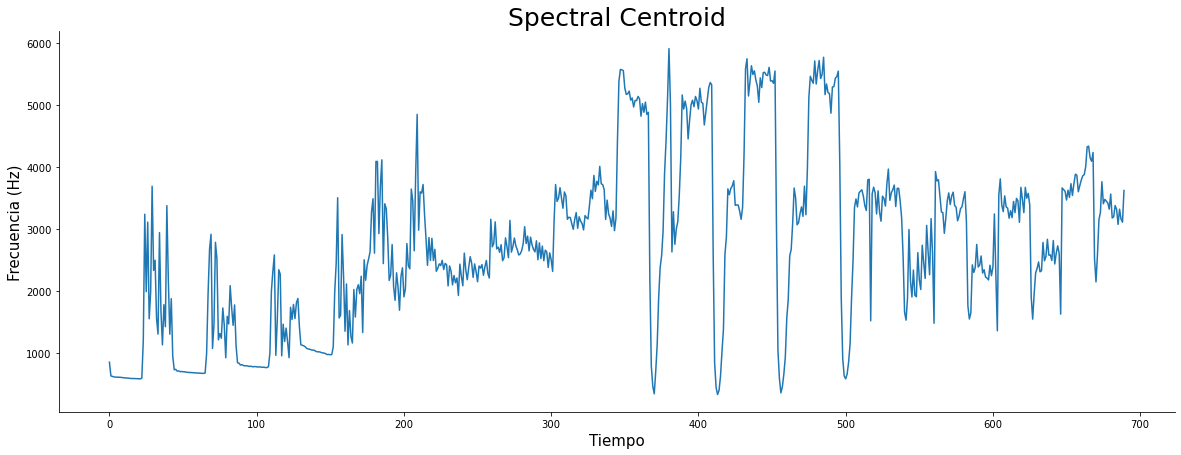

In [ ]:
plt.plot(spectralCentroid_results[0])
plt.title('Spectral Centroid', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()

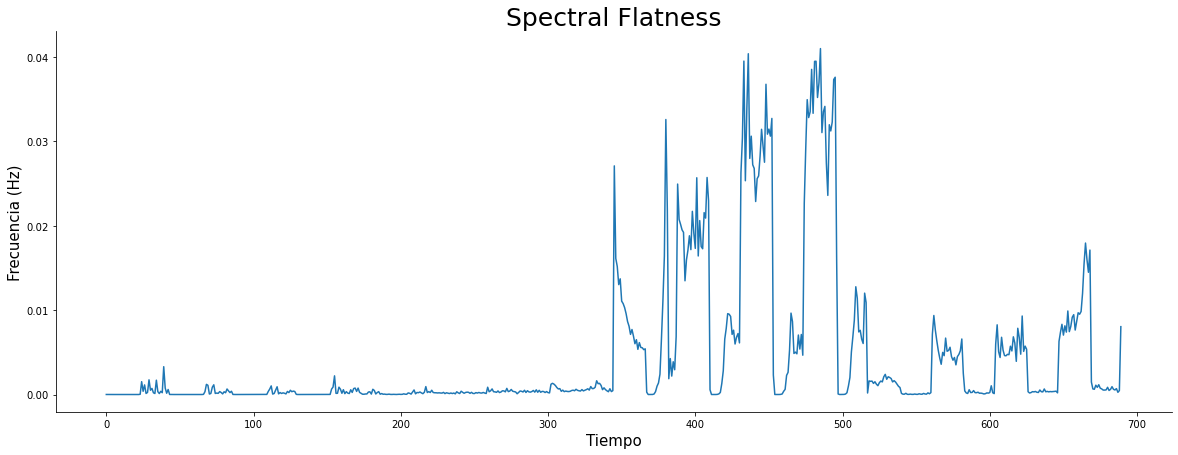

In [ ]:
plt.plot(spectralFlatness_results[0])
plt.title('Spectral Flatness', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()

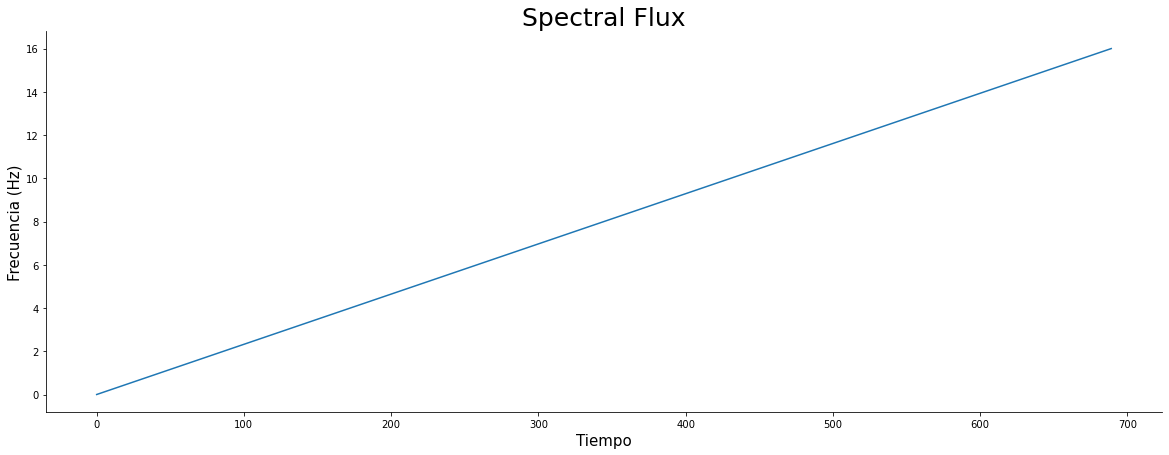

In [ ]:
plt.plot(spectralFlux_results[0])
plt.title('Spectral Flux', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()

# Pregunta 8: Experimentos con ventanas traslapadas

## Traslape al 25%

In [ ]:
spectralCentroid_results_25 = spectral_centroid(y = downMixed_audioTest, sr = 44100, n_fft=1024, hop_length=768)
spectralFlatness_results_25 = spectral_flatness(y = downMixed_audioTest, n_fft=1024, hop_length=768)
spectralFlux_results_25 = get_spectralFlux(downMixed_audioTest, hop_length=768)

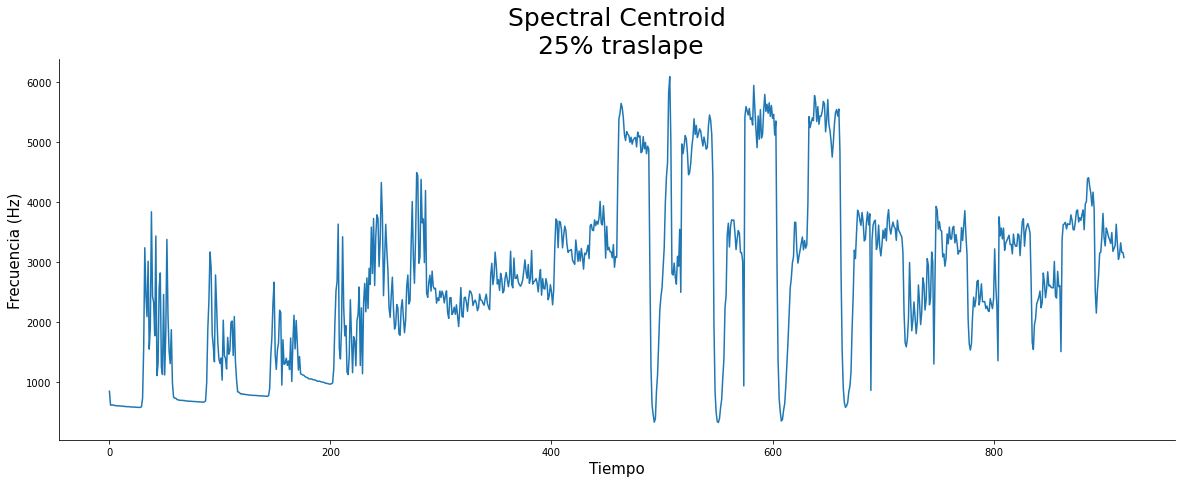

In [ ]:
plt.plot(spectralCentroid_results_25[0])
plt.title('Spectral Centroid\n 25% traslape', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()

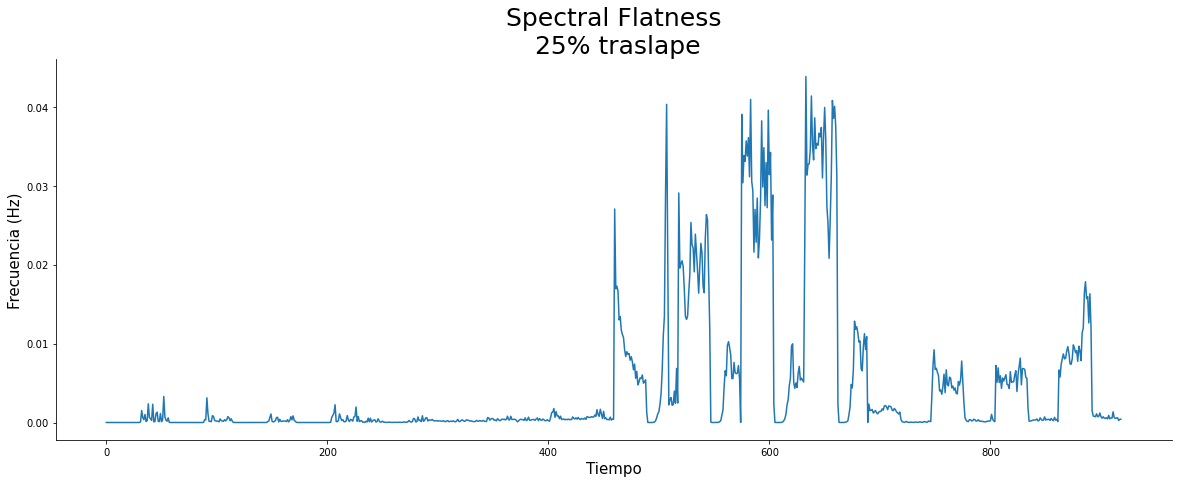

In [ ]:
plt.plot(spectralFlatness_results_25[0])
plt.title('Spectral Flatness\n 25% traslape', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()

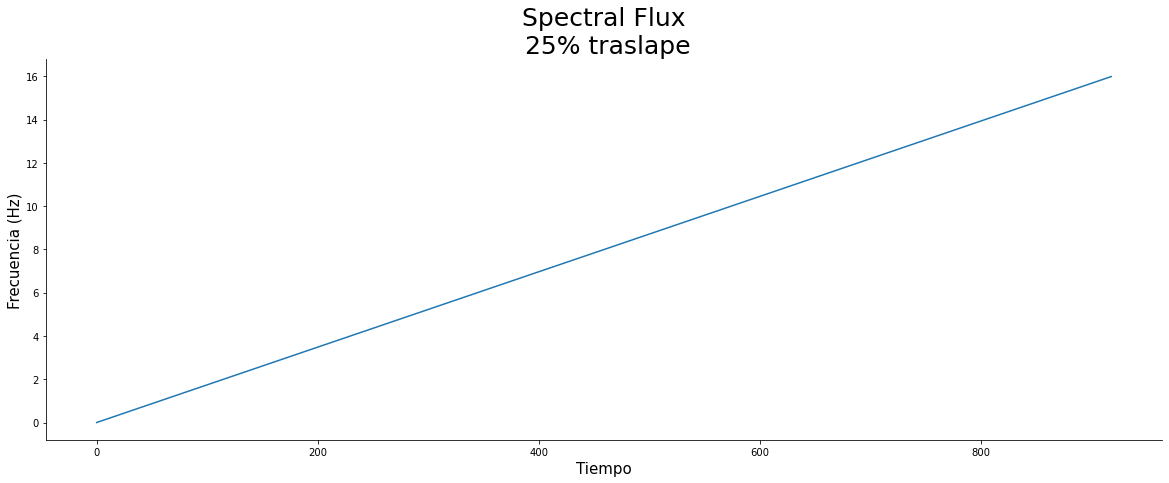

In [ ]:
plt.plot(spectralFlux_results_25[0])
plt.title('Spectral Flux\n 25% traslape', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()

## Traslape 50%

In [ ]:
spectralCentroid_results_50 = spectral_centroid(y = downMixed_audioTest, sr = 44100, n_fft=1024, hop_length=512)
spectralFlatness_results_50 = spectral_flatness(y = downMixed_audioTest, n_fft=1024, hop_length=512)
spectralFlux_results_50 = get_spectralFlux(downMixed_audioTest, hop_length=512)

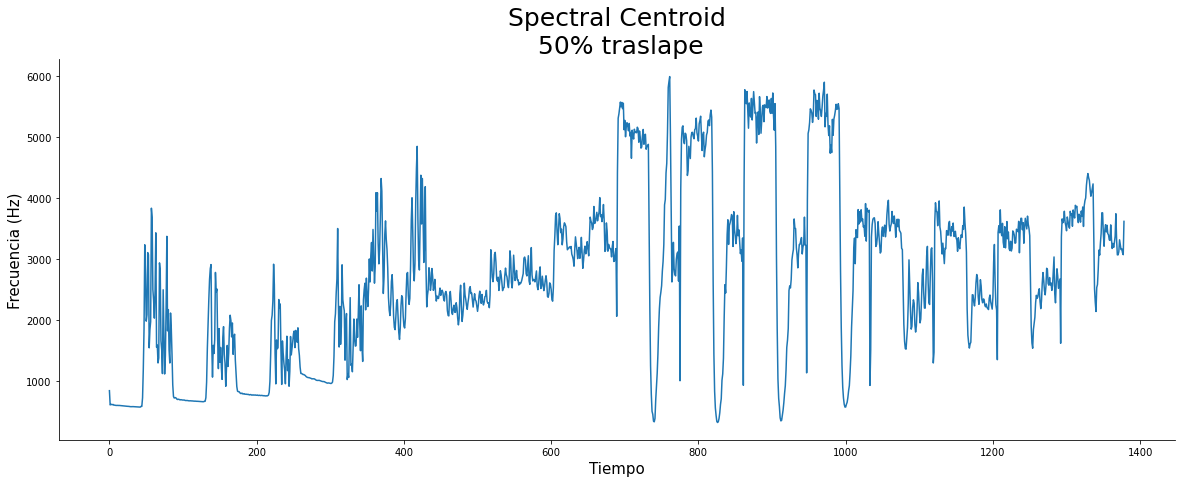

In [ ]:
plt.plot(spectralCentroid_results_50[0])
plt.title('Spectral Centroid\n 50% traslape', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()

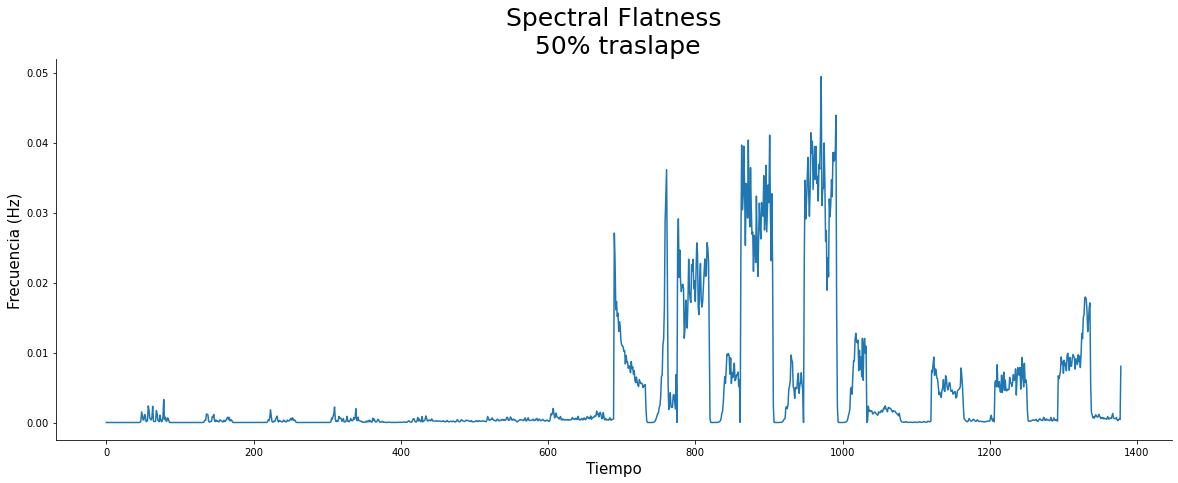

In [ ]:
plt.plot(spectralFlatness_results_50[0])
plt.title('Spectral Flatness\n 50% traslape', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()

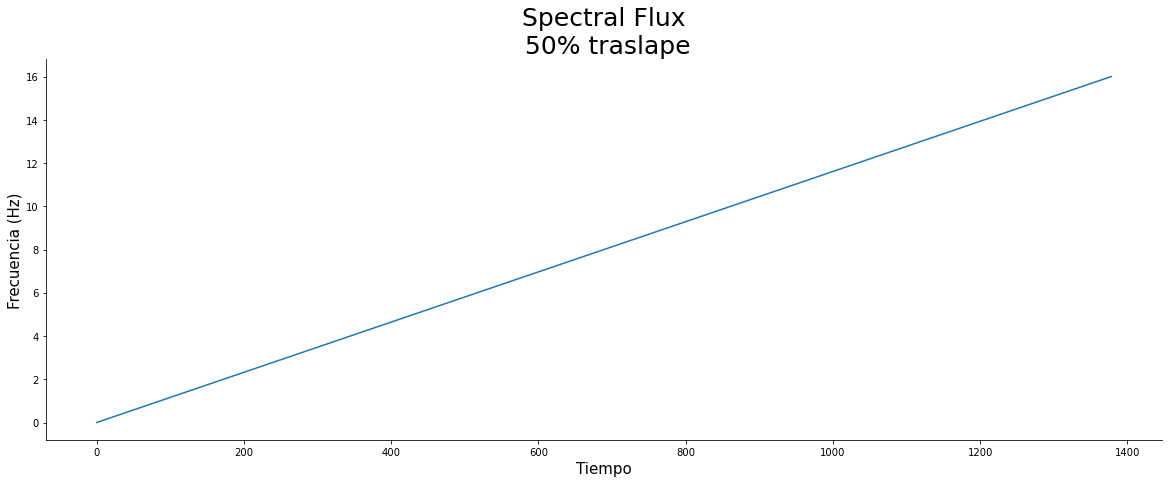

In [ ]:
plt.plot(spectralFlux_results_50[0])
plt.title('Spectral Flux\n 50% traslape', fontsize = 25)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel('Frecuencia (Hz)', fontsize = 15)
sn.despine()